[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/luleu96/GenAIinDD_Exercises/blob/work/Exercises/Exercise_1/RF_Eval.ipynb)

[Source: MTL Summer School 2024 Lab 1](https://github.com/valence-labs/mtl_summer_school_2024/tree/main/Lab1)

In [ ]:
!git clone https://github.com/luleu96/GenAIinDD_Exercises.git
%cd /content/GenAIinDD_Exercises

In [2]:
 # uncomment when in Colab
 !pip install umap-learn
 !pip install torch
 !pip install torch-geometric
 !pip install datamol
 !pip install molfeat
 !pip install --upgrade molfeat
 !pip install splito


In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import datamol as dm
import torch

from molfeat.trans.fp import FPVecTransformer
from molfeat.trans.graph.adj import PYGGraphTransformer
from typing import Any, List, Optional, Union
from contextlib import contextmanager
from matplotlib import pyplot as plt
from loguru import logger
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, precision_recall_fscore_support
from splito._scaffold_split import get_scaffold
from splito import ScaffoldSplit
from sklearn import clone



try:
    import umap  # type: ignore
except ImportError:
    umap = None

In [7]:
import os
working_dir = os.getcwd()


'/content/GenAIinDD_Exercises'

In [8]:
# load pre-processed data
data = pd.read_csv(os.path.join(working_dir, "Data", "egfr_pIC50_tutorial.csv"))
mol_col = "MOL_smiles"
data_col = "pIC50"

In [10]:
print("Shape of dataframe : ", data.shape)
data.head(10)

Shape of dataframe :  (4396, 4)


,MOL_smiles,pIC50,Gene_Symbol,Original_Entry_ID
0,CCOc1cc2ncc(C#N)c(Nc3ccc(OCc4nc5ccccc5s4)c(Cl)...,6.73,EGFR,CHEMBL175513
1,O=C1NC(=O)c2cc(Nc3ccccc3)c(Nc3ccccc3)cc21,6.80,EGFR,CHEMBL268868
2,CC(=O)NCCn1ccc2ncnc(Nc3ccc(Oc4cccc5sncc45)c(Cl...,8.54,EGFR,CHEMBL2048906
3,CCOc1ccc(-c2nn(C3CCCC3)c3ncnc(N)c23)cc1OC,5.85,EGFR,CHEMBL1240554
4,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,9.70,EGFR,CHEMBL553
5,COc1ccccc1C(Cc1coc2nc(N)nc(N)c12)C(C)C,4.74,EGFR,CHEMBL595757
6,O=C(c1cc2ccccc2[nH]1)c1cc2cc(O)ccc2[nH]1,5.29,EGFR,CHEMBL7735
7,Nc1ncnc2c1c(-c1ccc(O)cc1)cn2C1CCNC1,5.57,EGFR,CHEMBL354033
8,COc1cc2ncc(C(=O)O)c(Nc3ccc(F)c(Cl)c3)c2cc1OC,5.03,EGFR,CHEMBL1947123
9,Cc1ccc(C2CC(c3ccc(C)c(C)c3)=NN2C(N)=S)cc1,6.47,EGFR,CHEMBL1173813


Text(3, 550, 'IC50=10 uM ')

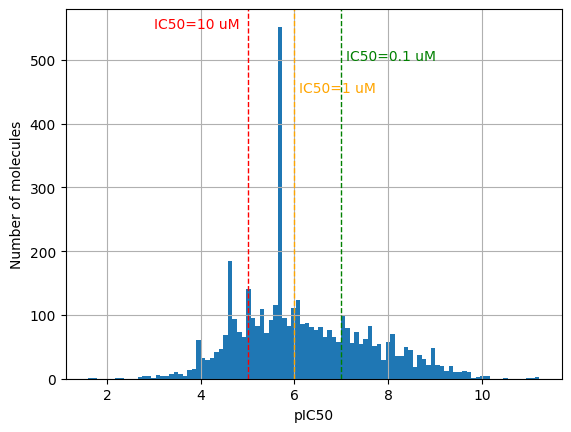

In [11]:
# plotting the dataset
# pIC50 of 6 as cut-off for active compound

fig = data[data_col].hist(bins=100)
plt.xlabel("pIC50")
plt.ylabel("Number of molecules")
fig.axvline(6, color="orange", linestyle="dashed", linewidth=1)
fig.annotate("IC50=1 uM", xy=(6, 450), xytext=(6.1, 450), color="orange")
fig.axvline(7, color="green", linestyle="dashed", linewidth=1)
fig.annotate("IC50=0.1 uM ", xy=(7, 500), xytext=(7.1, 500), color="green")
fig.axvline(5, color="red", linestyle="dashed", linewidth=1)
fig.annotate("IC50=10 uM ", xy=(3, 550), xytext=(3, 550), color="red")

In [12]:
# generate molecular fingerprints

fp_transformer = FPVecTransformer(kind="ecfp:4", length=2048)
features = fp_transformer(data[mol_col].values)

# or use `datamol.to_fp`
# features = np.array([dm.to_fp(smi) for smi inn data[mol_col].values])

print(features)
features.shape

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(4396, 2048)

In [13]:
# get the inhibition values
activities = data[data_col].values
activities

array([6.73, 6.8 , 8.54, ..., 6.21, 6.25, 5.8 ])

In [14]:
# Metrics
def pearsonr(y_true: np.ndarray, y_pred: np.ndarray):
    """Calculate a pearson r correlation"""
    return stats.pearsonr(y_true, y_pred).statistic


def spearman(y_true: np.ndarray, y_pred: np.ndarray):
    """Calculate a Spearman correlation"""
    return stats.spearmanr(y_true, y_pred).statistic


def model_performance(
    ml_model, test_x, test_y, threshold=6, verbose=True, reg_plot: bool = True
):
    """
    Helper function to calculate model performance

    Args
    ----------
    ml_model: model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)
    reg_plot: bool
        Scatter plot between predicion and true values.

    Returns
    -------
    tuple:
        MSE, Pearson R, Spearman, Precision, Recall and Fsocre on test set.
    """

    # Prediction class on test
    if isinstance(ml_model, RandomForestRegressor):
        test_pred = ml_model.predict(test_x)
    else:
        ml_model.eval()  # set model to evaluate mode
        test_pred = torch.cat([ml_model.predict(x) for x in test_x]).numpy().flatten()

    # Performance of model on test set
    ## regression
    mse = mean_squared_error(test_y, test_pred)
    pearsonr_score = pearsonr(test_y, test_pred)
    spearman_score = spearman(test_y, test_pred)
    ## classification
    precision, recall, fscore, _ = precision_recall_fscore_support(
        y_true=test_y > threshold, y_pred=test_pred > threshold, average="binary"
    )

    if verbose:
        # Print performance results
        logger.info(f"mean_squared_error: {mse:.2f}")
        logger.info(f"pearson r: {pearsonr_score:.2f}")
        logger.info(f"spearman: {spearman_score:.2f}")
        logger.info(f"precision: {precision:.2f}")
        logger.info(f"recall: {recall:.2f}")
        logger.info(f"fscore: {fscore:.2f}")

    if reg_plot:
        plot_df = pd.DataFrame({"y_true": test_y, "y_pred": test_pred})
        sns.set_style("whitegrid")
        fig = sns.regplot(data=plot_df, x="y_true", y="y_pred")
        fig.axvline(threshold, color="orange", linestyle="dashed", linewidth=1)
        fig.axhline(threshold, color="orange", linestyle="dashed", linewidth=1)

    return mse, pearsonr_score, spearman_score, precision, recall, fscore

In [15]:
# compute Murcko scaffolds
scaffolds = dm.utils.parallelized(
    fn=get_scaffold, inputs_list=data[mol_col].tolist(), n_jobs=-1, progress=True
)
print(
    f"There are unique {len(set(scaffolds))} scaffolds for {len(data)} molecules in the dataset."
)

  0%|          | 0/4396 [00:00<?, ?it/s]

There are unique 1777 scaffolds for 4396 molecules in the dataset.


In [16]:
# Create scaffold-base train-test split

spliter = ScaffoldSplit(
    smiles=data[mol_col].values, n_splits=5, test_size=0.2, random_state=111
)
train_index, test_index = next(spliter.split(features))

print("Training data size:", len(train_index))
print("Test data size:", len(test_index))

Training data size: 3355
Test data size: 1041


In [17]:
# visualize chemspace

@contextmanager
def create_figure(
    n_plots: int,
    n_cols: Optional[int] = None,
    fig_base_size: float = 8,
    w_h_ratio: float = 0.5,
    dpi: int = 150,
    seaborn_theme: Optional[str] = "whitegrid",
):
    """Creates a figure with the desired size and layout"""

    if seaborn_theme is not None:
        sns.set_theme(style=seaborn_theme)

    if n_cols is None or n_cols > n_plots:
        n_cols = n_plots

    n_rows = n_plots // n_cols
    if n_plots % n_cols > 0:
        n_rows += 1

    fig_w = fig_base_size * n_cols
    fig_h = fig_base_size * w_h_ratio * n_rows

    # Create the figure
    fig, axes = plt.subplots(
        nrows=n_rows,
        ncols=n_cols,
        figsize=(fig_w, fig_h),
        constrained_layout=True,
        dpi=dpi,
    )
    axes = np.atleast_1d(axes)
    axes = axes.flatten()
    yield fig, axes

    # Remove unused axes
    _ = [fig.delaxes(a) for a in axes[n_plots:]]


def visualize_chemspace(
    X: np.ndarray,
    y: Optional[Union[List[np.ndarray], np.ndarray]] = None,
    labels: Optional[List[str]] = None,
    n_cols: int = 2,
    fig_base_size: float = 8,
    w_h_ratio: float = 0.5,
    dpi: int = 150,
    seaborn_theme: Optional[str] = "whitegrid",
    **umap_kwargs: Any,
):
    """Plot the coverage in chemical space. Also, color based on the target values.

    Args:
        X: Array the molecular features.
        y: A list of arrays with the target values.
        labels: Optional list of labels for each set of features.
        n_cols: Number of columns in the subplots.
        fig_base_size: Base size of the plots.
        w_h_ratio: Width/height ratio.
        dpi: DPI value of the figure.
        seaborn_theme: Seaborn theme.
        **umap_kwargs: Keyword arguments for the UMAP algorithm.
    """

    if umap is None:
        raise ImportError(
            "Please run `pip install umap-learn` to use UMAP visualizations for the chemspace."
        )

    if isinstance(y, np.ndarray):
        y = [y]

    if y is None:
        y = [None]

    if labels is None:
        labels = ["" for _ in range(len(y))]

    if len(y) != len(labels):
        raise ValueError("`labels` and `y` must have the same length.")

    embedding = umap.UMAP(**umap_kwargs).fit_transform(X)
    umap_0, umap_1 = embedding[:, 0], embedding[:, 1]

    with create_figure(
        n_plots=len(y),
        n_cols=n_cols,
        fig_base_size=fig_base_size,
        w_h_ratio=w_h_ratio,
        dpi=dpi,
        seaborn_theme=seaborn_theme,
    ) as (fig, axes):
        for idx, (y_i, label) in enumerate(zip(y, labels)):
            ax = sns.scatterplot(
                x=umap_0,
                y=umap_1,
                hue=y_i,
                ax=axes[idx],
                palette="Set2",
                edgecolor="none",
            )
            ax.set_xlabel("Component 0")
            ax.set_xlabel("Component 1")
            ax.set_title(label)
            ax.collections[0].set_sizes([8])
    return fig


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


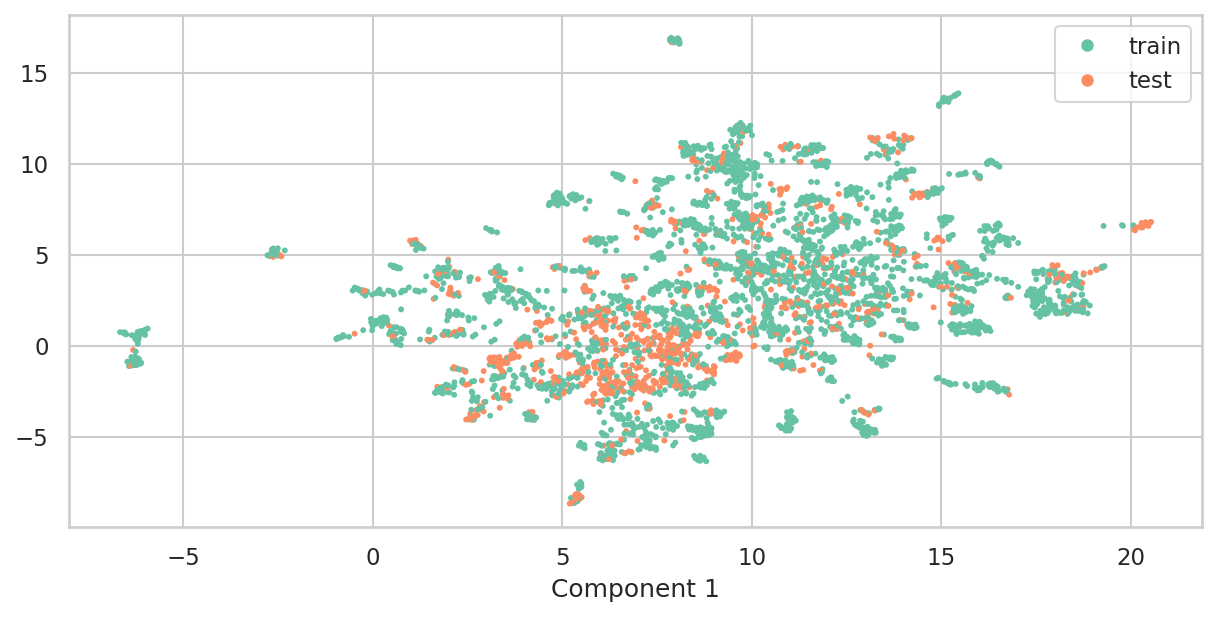

In [18]:
# visualize their distribution within the chemical space

split_labels = np.full(len(features), "train", dtype=object)
split_labels[test_index] = "test"
fig = visualize_chemspace(
    X=features, y=[split_labels], metric="jaccard", min_dist=0.5, random_state=42
)

In [19]:
# get the features and bioactivities of the training set
train_x, train_y = features[train_index], activities[train_index]

print("Training set data shape:", train_x.shape)

Training set data shape: (3355, 2048)


In [20]:
# define a model and train
from sklearn.ensemble import RandomForestRegressor

# set model parameter for random forest
rf_param = {
    "n_estimators": 100,  # number of trees to grows
    "criterion": "squared_error",  # cost function to be optimized for a split
}

RF_model = RandomForestRegressor(**rf_param)

In [21]:
# fit model on single train split
RF_model.fit(train_x, train_y)

RandomForestRegressor()

2024-10-17 12:24:55.561 | INFO     | __main__:model_performance:56 - mean_squared_error: 1.00
2024-10-17 12:24:55.565 | INFO     | __main__:model_performance:57 - pearson r: 0.76
2024-10-17 12:24:55.569 | INFO     | __main__:model_performance:58 - spearman: 0.77
2024-10-17 12:24:55.571 | INFO     | __main__:model_performance:59 - precision: 0.82
2024-10-17 12:24:55.574 | INFO     | __main__:model_performance:60 - recall: 0.90
2024-10-17 12:24:55.576 | INFO     | __main__:model_performance:61 - fscore: 0.86


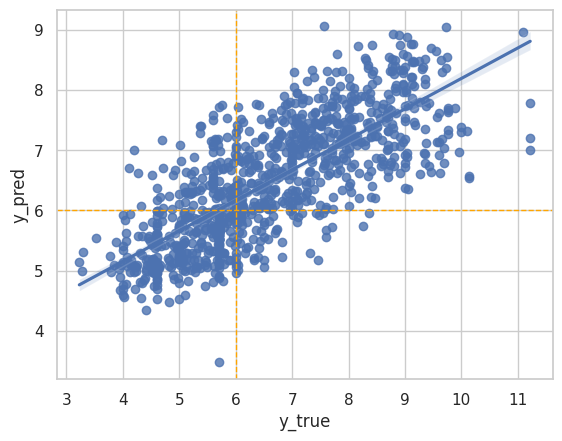

In [22]:
# get the features and bioactivities of the test set
test_x, test_y = features[test_index], activities[test_index]

# compute the performance and generate the plot
res = model_performance(RF_model, test_x, test_y, verbose=True, threshold=6)

In [23]:
# dump the transformer and model to pickle file
import pickle

with open("rf_regressor.pkl", "wb") as fout:
    pickle.dump((fp_transformer, RF_model), fout)

In [24]:
# define cross validation process and metrics

def cross_validation(
    ml_model, spliter, features, activities, verbose=True, threshold=6
):
    """
    Machine learning model training and validation in a cross-validation loop.
    """
    # Results for each of the cross-validation folds
    pearsonr_per_fold = []
    spearman_per_fold = []
    mse_per_fold = []
    precision_per_fold = []
    recall_per_fold = []
    fscore_per_fold = []

    # Loop over the folds
    for train_index, test_index in spliter.split(features):

        # clone the newly initiated model
        fold_model = clone(ml_model)

        # Training

        # Convert the fingerprint and the label to a list
        train_x = features[train_index]
        train_y = activities[train_index]

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = features[test_index]
        test_y = activities[test_index]

        # Performance for each fold
        mse, pearsonr_score, spearman_score, precision, recall, fscore = (
            model_performance(
                ml_model=fold_model,
                test_x=test_x,
                test_y=test_y,
                verbose=verbose,
                threshold=threshold,
                reg_plot=False,
            )
        )

        # Save results
        mse_per_fold.append(mse)
        pearsonr_per_fold.append(pearsonr_score)
        spearman_per_fold.append(spearman_score)
        precision_per_fold.append(precision)
        recall_per_fold.append(recall)
        fscore_per_fold.append(fscore)

    # Print statistics of results
    print(
        f"Mean mean squared error: {np.mean(mse_per_fold):.2f} \t"
        f"and std : {np.std(mse_per_fold):.2f} \n"
        f"Mean pearsonr: {np.mean(pearsonr_per_fold):.2f} \t"
        f"and std : {np.std(pearsonr_per_fold):.2f} \n"
        f"Mean spearman: {np.mean(spearman_per_fold):.2f} \t"
        f"and std : {np.std(spearman_per_fold):.2f} \n"
        f"Mean precision: {np.mean(precision_per_fold):.2f} \t"
        f"and std : {np.std(precision_per_fold):.2f} \n"
        f"Mean recall: {np.mean(recall_per_fold):.2f} \t"
        f"and std : {np.std(recall_per_fold):.2f} \n"
        f"Mean fscore: {np.mean(fscore_per_fold):.2f} \t"
        f"and std : {np.std(fscore_per_fold):.2f} \n"
    )

    meric_per_fold = {
        "mse": mse_per_fold,
        "pearsonr": pearsonr_per_fold,
        "spearman": spearman_per_fold,
        "precision": precision_per_fold,
        "recall": recall_per_fold,
        "fscore": fscore_per_fold,
    }
    sns.boxplot(meric_per_fold, palette="pastel").set(
        title="Evaluation cross 10 splits"
    )




In [ ]:
spliter = ScaffoldSplit(
    smiles=data[mol_col].values, n_splits=10, test_size=0.2, random_state=111
)
cross_validation(
    ml_model=RandomForestRegressor(**rf_param),
    spliter=spliter,
    features=features,
    activities=activities,
    threshold=6,
    verbose=False,
)
